# Open Exploration using the MORO Policies

## 1. Introduction

The nine (9) policies which were found on the pareto front in [notebook 3](LINK) are evaluated through open exploration. 

In [1]:
# Import every package we need

import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time

from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

In [2]:
from ema_workbench import (Model, CategoricalParameter,
                           ScalarOutcome, IntegerParameter, RealParameter)

from ema_workbench import (Model, MultiprocessingEvaluator, Policy, Scenario, SequentialEvaluator)

from ema_workbench.em_framework.evaluators import perform_experiments, optimize
from ema_workbench.em_framework.samplers import sample_uncertainties
from ema_workbench.analysis import prim, dimensional_stacking, cart, parcoords
from ema_workbench.util import ema_logging, utilities

ema_logging.log_to_stderr(ema_logging.INFO)

C:\Users\newbi\Anaconda3\lib\site-packages\sklearn\externals\six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)
C:\Users\newbi\Anaconda3\lib\importlib\_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)


<Logger EMA (DEBUG)>

In [3]:
# Load in self-created visualization functions
from visualization_functions import histogram_maker, mean_outcomes, aggregate_outcomes, scatter_maker, pairplot_maker, boxplot_histogram_maker, boxplot_maker

In [4]:
# Initialize model parameters
# from model.dike_model_function import DikeNetwork  # @UnresolvedImport
# from model.problem_formulation import get_model_for_problem_formulation

# dike_model, planning_steps = get_model_for_problem_formulation(5)

# with MultiprocessingEvaluator(dike_model) as evaluator:
#     results = evaluator.perform_experiments(scenarios=50,policies=policies)

# from ema_workbench.util.utilities import (save_results, load_results)

# save_results(results, "Outcomes/MOROpolicies50Scenarios.csv" )

In [5]:
import pickle

results_MORO, convergence = pickle.load(open('Outcomes/MORO_s50_nfe20000.pkl', 'rb'))
results_MORO.head()

,0_RfR 0,0_RfR 1,0_RfR 2,1_RfR 0,1_RfR 1,1_RfR 2,2_RfR 0,2_RfR 1,2_RfR 2,3_RfR 0,...,A.4_DikeIncrease 1,A.4_DikeIncrease 2,A.5_DikeIncrease 0,A.5_DikeIncrease 1,A.5_DikeIncrease 2,Damage Score,Deaths Score,Dike Invest Score,RfR Invest Score,Evac Score
0,0,0,0,0,0,0,1,1,1,0,...,3,2,2,1,1,1.964370e+14,1.861056e-06,1.196531e+18,1.178112e+16,3.252648e+08
1,1,1,0,0,0,0,1,1,1,0,...,3,2,2,1,1,1.133849e+11,1.143893e-07,1.196531e+18,9.305655e+18,0.000000e+00
2,0,0,1,0,0,0,1,1,1,0,...,3,2,2,1,1,7.853715e+11,9.160793e-08,1.196531e+18,6.272040e+18,1.574746e+06
3,0,0,0,0,0,0,1,1,1,0,...,3,2,2,1,1,1.964370e+14,1.292400e-04,1.196531e+18,1.178112e+16,0.000000e+00
4,0,0,0,0,0,0,0,1,1,0,...,3,2,2,1,1,1.980599e+14,1.307336e-04,1.196531e+18,7.906444e+17,0.000000e+00


In [6]:
policies = []
for row in range(results_MORO.shape[0]):
    policies.append(
        Policy(name = row, **results_MORO.iloc[row,:-5].to_dict())  # Do not include the damage scores
    )

In [7]:
from ema_workbench.util.utilities import (save_results, load_results)

results = load_results('Outcomes/MOROpolicies400Scenarios.csv')

experiments, outcomes = results
outcomes = pd.DataFrame(outcomes)
experiments = pd.DataFrame(experiments)
results = experiments.join(outcomes)
results = results.drop(columns="model")
results.head()

[MainProcess/INFO] results loaded succesfully from C:\Users\newbi\project-local\Model-based-decision-making\Outcomes\MOROpolicies400Scenarios.csv


,A.0_ID flood wave shape,A.1_Bmax,A.1_Brate,A.1_pfail,A.2_Bmax,A.2_Brate,A.2_pfail,A.3_Bmax,A.3_Brate,A.3_pfail,...,A.3_Dike Investment Costs 2,A.3_Expected Number of Deaths 2,A.4_Expected Annual Damage 2,A.4_Dike Investment Costs 2,A.4_Expected Number of Deaths 2,A.5_Expected Annual Damage 2,A.5_Dike Investment Costs 2,A.5_Expected Number of Deaths 2,RfR Total Costs 2,Expected Evacuation Costs 2
0,16.0,95.366886,1.0,0.334887,278.890461,10.0,0.602767,173.139661,1.5,0.364909,...,5.639157e+07,0.0,0.0,5.585544e+07,0.0,0.0,6.071198e+07,0.0,30700000.0,0.0
1,20.0,311.236496,1.5,0.648404,102.259704,1.0,0.888705,84.422554,1.5,0.359334,...,5.639157e+07,0.0,0.0,5.585544e+07,0.0,0.0,6.071198e+07,0.0,30700000.0,0.0
2,102.0,300.059210,1.0,0.449451,111.094021,1.5,0.935721,208.285945,10.0,0.006956,...,5.639157e+07,0.0,0.0,5.585544e+07,0.0,0.0,6.071198e+07,0.0,30700000.0,0.0
3,69.0,128.702886,10.0,0.595469,119.355882,1.0,0.872678,146.418145,1.0,0.685500,...,5.639157e+07,0.0,0.0,5.585544e+07,0.0,0.0,6.071198e+07,0.0,30700000.0,0.0
4,44.0,278.386091,10.0,0.190867,149.400545,1.0,0.153690,335.927277,1.5,0.905726,...,5.639157e+07,0.0,0.0,5.585544e+07,0.0,0.0,6.071198e+07,0.0,30700000.0,0.0


In [8]:
aggregate_outcomes(results, "Expected Annual Damage")
aggregate_outcomes(results, "Expected Number of Deaths")

## 2. Data visualization

Visual examination on the data to have a better understanding of what is happening in the model.

### 2.1 Histogram plots

A distribution of the outcomes over location and timesteps are given. These histograms only showcase the expected annual damages and the expected number of deaths.

#### 2.1.1 Expected Number of Deaths

In [ ]:
histogram_maker(results, "Expected Number of Deaths")

#### 2.1.2 Expected Annual Damage

In [ ]:
histogram_maker(results, "Expected Annual Damage")

The histograms look very promising, as the ranges of deaths and damages over the locations are very low. Locations A.1 and A.2 in the first timestep however includes scenarios where the damages and deaths can be high. 

### 2.2 Mean outcomes

In [ ]:
# Select the outcomes you want the mean, for base case the costs are not very interesting.
outcome_names = ["Expected Annual Damage", "Expected Number of Deaths", "Expected Evacuation Costs", "RfR Total Costs",
                "Dike Investment Costs"]

mean_outcomes(results, outcome_names)

The means graphs show the same conclusion as with the histograms. A.1 and A.2 have a higher mean in damages and deaths in the first timestep whereas the other locations are incredibly robust. 

### 2.3 Pairplot

In [ ]:
# Takes more time to load than other visualizations
interact(pairplot_maker, results=fixed(results), n=[1, 2, 3], location=["A.1", "A.2", "A.3", "A.4", "A.5"]);

The pairplot of A.1 and A.2 in timestep 1 show the policies color coded as well. The relationship of deaths and damages with pfail in this case has changed, the range of pfail in which damages and deaths occur is now lower. 

### 2.4 Boxplots across policies

Caution when looking at the plots, because the legend is not fixed! 

In [9]:
aggregate_outcomes(results, "Dike Investment Costs")
aggregate_outcomes(results, "RfR Total Costs")
aggregate_outcomes(results, "Expected Evacuation Costs")
results["Total Investment Costs"] = results.iloc[:, -3:].sum(axis =1)

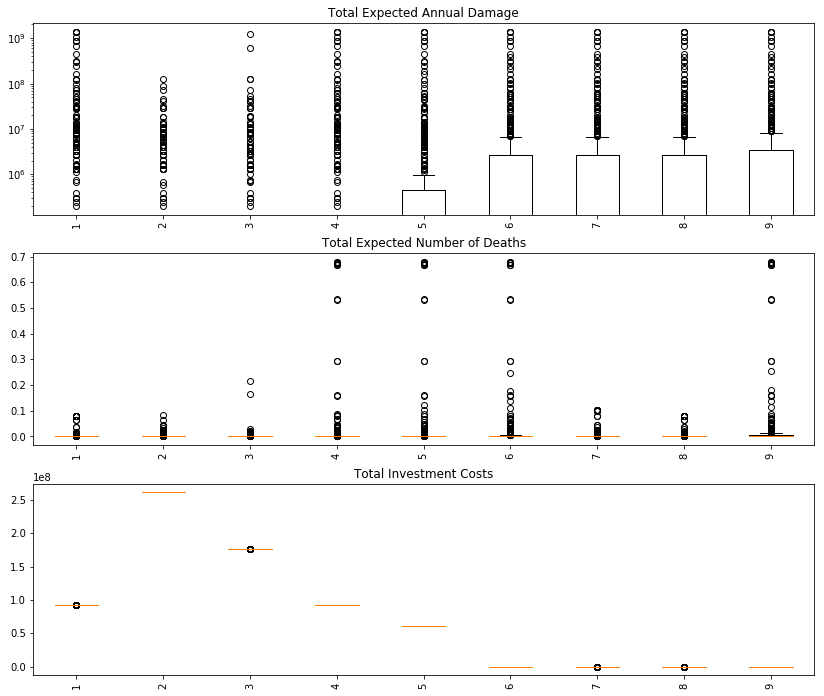

In [21]:
total_outcomes = ["Total Expected Annual Damage", "Total Expected Number of Deaths", "Total Investment Costs"]

boxplot_maker(results, total_outcomes)

Compared to the open exploration of the 75 policies, the mean and the interquartile range perform better than most policies in damages. The outliers in deaths of policy 1, 2, 7, and 8 do not go above 0.1 even, however outliers in 4, 5, 6, and 9 are relatively high - even being higher than the ranges in the 75 policies. 

The policies however are optimized for the worst ranges in A.1 and A.3 pfails, while this is across the full uncertainty space. It is noticable that policies 1, 2, and 3 perform good in deaths and damages. 

### 2.5 Scatter plots

#### 2.5.1 Expected Number of Deaths

Plot Expected Number of Deaths(Scatterplot)
This is timestep 0


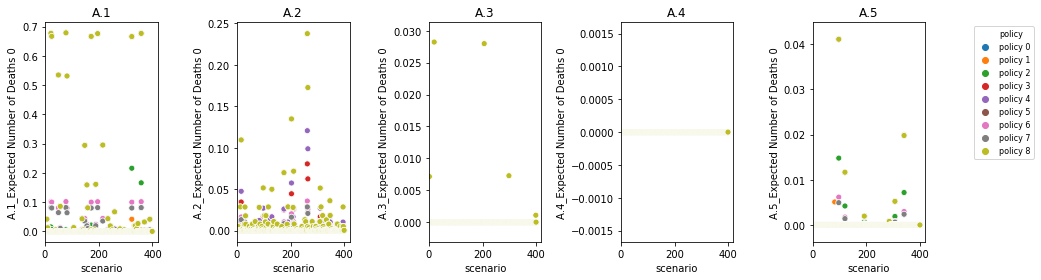

This is timestep 1


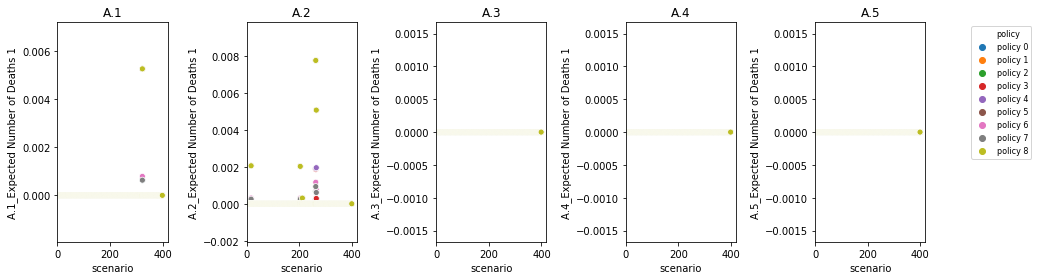

This is timestep 2


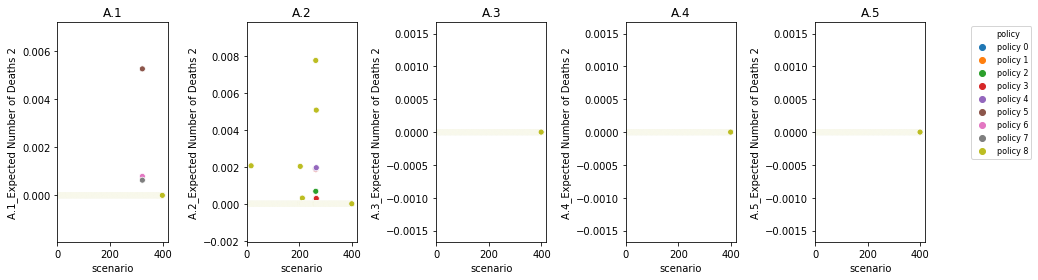

In [22]:
scatter_maker(results, "Expected Number of Deaths")

#### 2.5.2 Expected Annual Damage

Plot Expected Annual Damage(Scatterplot)
This is timestep 0


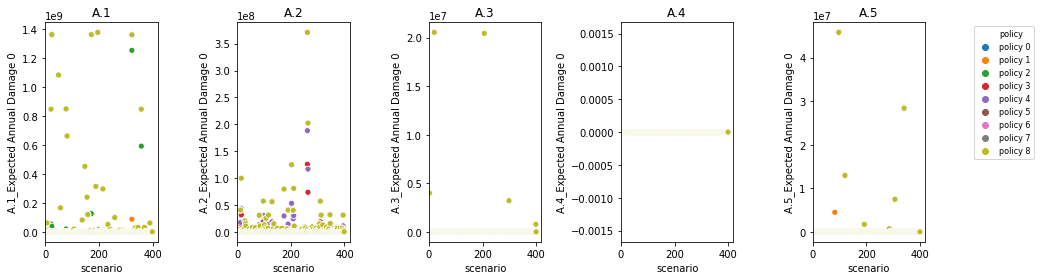

This is timestep 1


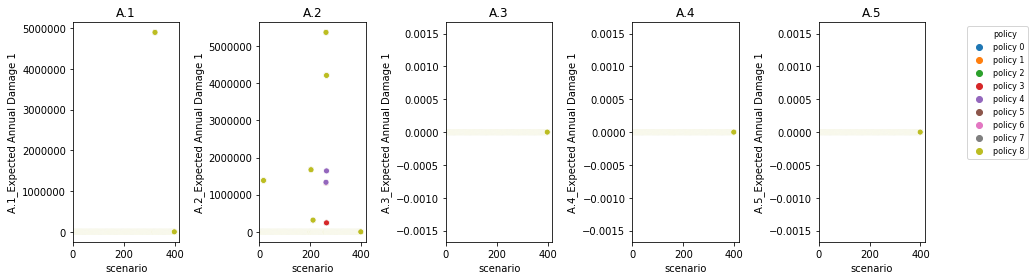

This is timestep 2


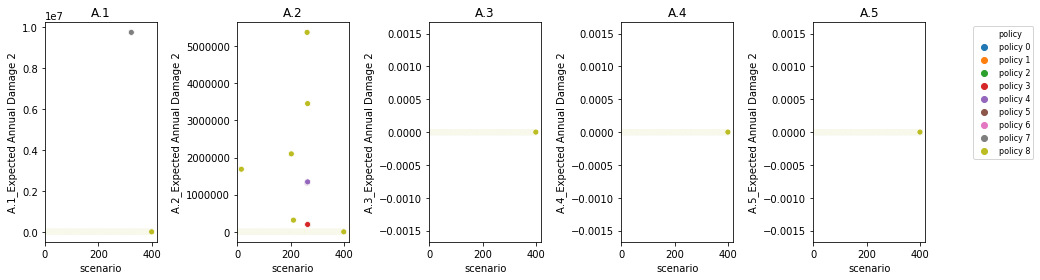

In [23]:
scatter_maker(results, "Expected Annual Damage")

These scatterplots show several important implications for the policies. It most commonly occurs in A.1 and A.2, however A.3 and A.5 are affected as well in the first time step. Another mention is that A.2 is affected in all time steps. When reviewing it is clear that policy 8 is not as robust as the other policies, due to the high number of scenarios in which the policy doesn't mitigate the damages and deaths. Other policies have outliers in specific locations, however it is not as systematic as policy 8. It is important to be mindful of these disadvantages as well for the final policy set. It is interesting to note that most outliers happen in A.1, while MORO has already taken the scenario space in which A.1pfail is low. 

### 2.6 Trade-offs

A parallel coordinates plot is created to visualize any apparent trade-offs in the created policies. 

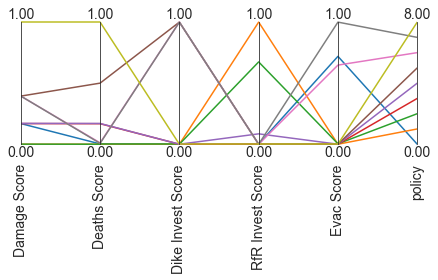

,Damage Score,Deaths Score,Dike Invest Score,RfR Invest Score,Evac Score,policy
0,0.169045,0.002302,0.000000e+00,0.001266,0.719602,0
1,0.000000,0.000030,0.000000e+00,1.000000,0.000000,1
2,0.000579,0.000000,0.000000e+00,0.674003,0.003484,2
3,0.169045,0.168033,2.167261e-07,0.001266,0.000000,3
4,0.170442,0.169976,1.118503e-07,0.084964,0.000000,4
5,0.394087,0.500243,1.000000e+00,0.000000,0.000000,5
6,0.394087,0.011139,1.000000e+00,0.000000,0.647903,6
7,0.394087,0.007086,1.000000e+00,0.000000,1.000000,7
8,1.000000,1.000000,2.114056e-07,0.000000,0.000000,8


In [125]:
data = results_MORO.iloc[:, -5:]
data_norm = (data - data.min()) / (data.max() - data.min())

# Added the policy column as it helps as a 'legend'
data_norm["policy"] = data.index
limits = parcoords.get_limits(data_norm)

paraxes = parcoords.ParallelAxes(limits)
paraxes.plot(data_norm)
plt.show()
data_norm

The policies will also be visualized for a quick inspection.

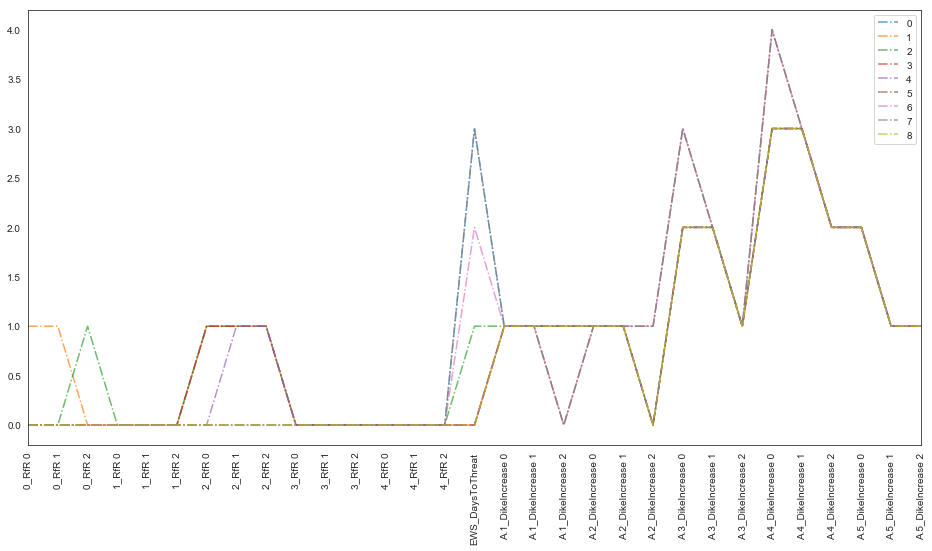

In [124]:
for i in results_MORO.index:
    results_MORO.iloc[i, :-5].plot('line', linestyle = '-.', alpha = 0.7)

fig = plt.gcf()
fig.set_size_inches(16, 8)
plt.xticks(np.arange(31), y.keys(), rotation=90)
plt.legend()
plt.show()

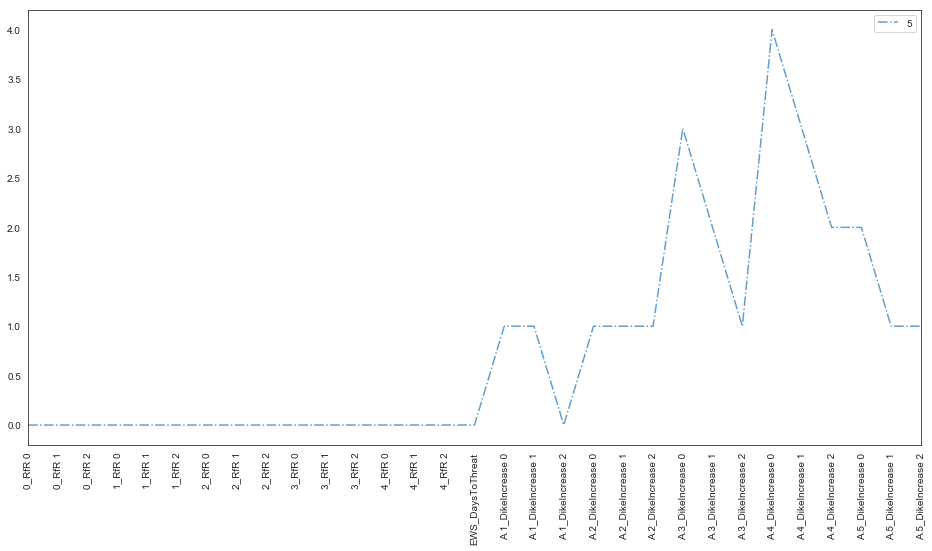

In [132]:
results_MORO.iloc[5, :-5].plot('line', linestyle = '-.', alpha = 0.7)

fig = plt.gcf()
fig.set_size_inches(16, 8)
plt.xticks(np.arange(31), y.keys(), rotation=90)
plt.legend()
plt.show()

An inspection shows that policies from 5 onwards Room for the River is not projected.

## 3. Scenario Discovery

### 3.1 General Outcomes

In [ ]:
boxplot_histogram_maker(results)

In [ ]:
x = results.iloc[:, :19] # Only take the uncertainties

y_deaths = results['Total Expected Number of Deaths'].values
y_deaths = y_deaths > np.percentile(y_deaths, 95)

In [ ]:
prim_alg = prim.Prim(x, y_deaths, threshold=0.55, peel_alpha=0.005)
box1 = prim_alg.find_box()

box1.show_tradeoff()
plt.show()

In [ ]:
box1.inspect()
box1.inspect(style='graph')
plt.show()

In [ ]:
box1.select(-1)
box1.show_pairs_scatter()
fig = plt.gcf()
fig.set_size_inches(12,12)
plt.show()

### 3.2 Further investigation on specific locations

Check A.1 as well..

Further discovery of location A2 and time step 1 as the scatter plots and histograms showed that the policies are not robust yet. 

In [ ]:
y_deaths_A1 = results["A.1_Expected Number of Deaths 0"]
y_deaths_A1 = y_deaths_A1 > np.percentile(y_deaths_A1, 90)

In [ ]:
prim_alg = prim.Prim(x, y_deaths_A1, threshold=0.40, peel_alpha=0.0001)
box1 = prim_alg.find_box()

box1.show_tradeoff()
plt.show()

In [ ]:
box1.select(-1)
box1.show_pairs_scatter()
fig = plt.gcf()
fig.set_size_inches(12,12)
plt.show()

In [ ]:
cart_alg = cart.CART(x, y_deaths_A1, 0.05)
cart_alg.build_tree()

print(cart_alg.stats_to_dataframe())
print(cart_alg.boxes_to_dataframe())

cart_alg.show_tree()
fig = plt.gcf()
fig.figure(figsize = 12, 12)
plt.show()

In [ ]:
y_damages_A1 = results["A.1_Expected Annual Damage 0"]
y_damages_A1 = y_damages_A1 > np.percentile(y_damages_A1, 90)

In [ ]:
prim_alg = prim.Prim(x, y_deaths_A1, threshold=0.40, peel_alpha=0.1)
box1 = prim_alg.find_box()

box1.show_tradeoff()
plt.show()

In [ ]:
box1.select(-1)
box1.show_pairs_scatter()
fig = plt.gcf()
fig.set_size_inches(12,12)
plt.show()

In [ ]:
cart_alg = cart.CART(x, y_damages_A1, 0.05)
cart_alg.build_tree()

print(cart_alg.stats_to_dataframe())
print(cart_alg.boxes_to_dataframe())

cart_alg.show_tree()
fig = plt.gcf()
fig.figure(figsize = 12, 12)
plt.show()

## A.2

In [ ]:
# A.2_Expected Annual Damage 0
# A.2_Expected Number of Deaths 0

y_deaths_A2 = results["A.2_Expected Number of Deaths 0"]
y_deaths_A2 = y_deaths_A2 > np.percentile(y_deaths_A2, 90)

In [ ]:
prim_alg = prim.Prim(x, y_deaths_A2, threshold=0.40, peel_alpha=0.0001)
box1 = prim_alg.find_box()

box1.show_tradeoff()
plt.show()

In [ ]:
box1.inspect()
box1.inspect(style='graph')
plt.show()

In [ ]:
box1.select(-1)
box1.show_pairs_scatter()
fig = plt.gcf()
fig.set_size_inches(12,12)
plt.show()

In [ ]:
cart_alg = cart.CART(x, y_deaths_A2, 0.05)
cart_alg.build_tree()

print(cart_alg.stats_to_dataframe())
print(cart_alg.boxes_to_dataframe())

cart_alg.show_tree()
fig = plt.gcf()
fig.figure(figsize = 12, 12)
plt.show()

In [ ]:
y_damages_A2 = results["A.2_Expected Annual Damage 0"]
y_damages_A2 = y_damages_A2 > np.percentile(y_damages_A2, 90)

In [ ]:
prim_alg = prim.Prim(x, y_damages_A2, threshold=0.40, peel_alpha=0.1)
box1 = prim_alg.find_box()

box1.show_tradeoff()
plt.show()

In [ ]:
box1.select(-1)
box1.show_pairs_scatter()
fig = plt.gcf()
fig.set_size_inches(12,12)
plt.show()

In [ ]:
# PCA: same coverage

# x_numeric = x.select_dtypes(exclude=pd.CategoricalDtype)
# x_categorical = x.select_dtypes(include=pd.CategoricalDtype)

# rotated_experiments, rotation_matrix = prim.pca_preprocess(x_numeric, y_damages_A2)

# rotated_x = pd.concat([rotated_experiments, x_categorical], axis=1)

# prim_obj = prim.Prim(rotated_x, y_damages_A2, threshold=0.1, peel_alpha=0.1)
# box1 = prim_obj.find_box()

# box1.show_tradeoff()
# plt.show()

In [ ]:
cart_alg = cart.CART(x, y_damages_A2, 0.05)
cart_alg.build_tree()

print(cart_alg.stats_to_dataframe())
print(cart_alg.boxes_to_dataframe())

cart_alg.show_tree()
fig = plt.gcf()
fig.figure(figsize = 12, 12)
plt.show()